In [72]:
from sklearn.datasets import load_breast_cancer

In [73]:
from sklearn.model_selection import train_test_split

In [74]:
import numpy as np

In [75]:
X,y = load_breast_cancer(return_X_y=True)

In [76]:
class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [77]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Sum-of-squares cost function value averaged over all
      training samples in each epoch.

        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

In [78]:
class AdalineGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Sum-of-squares cost function value in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            # Please note that the "activation" method has no effect
            # in the code since it is simply an identity function. We
            # could write `output = self.net_input(X)` directly instead.
            # The purpose of the activation is more conceptual, i.e.,  
            # in the case of logistic regression (as we will see later), 
            # we could change it to
            # a sigmoid function to implement a logistic regression classifier.
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [80]:
y_train.shape

(398,)

In [81]:
X_test.shape

(171, 30)

In [82]:
from sklearn.linear_model import Perceptron as Perceptron_sklearn
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

In [83]:
perceptron_alg = Perceptron()
adalineGD = AdalineGD()
adalineSGD = AdalineSGD()

perceptron_sklearn = Perceptron_sklearn()
sklearnSGD = SGDClassifier()
logistic_regression = LogisticRegression()

In [84]:
adalineSGD_mini_batches = AdalineSGD()

In [85]:
perceptron_alg.fit(X_train, y_train)

In [86]:
adalineGD.fit(X_train, y_train)

C:\Users\brena\AppData\Local\Temp\ipykernel_14788\3180728454.py:61: RuntimeWarning: overflow encountered in square
  cost = (errors**2).sum() / 2.0
C:\Users\brena\anaconda3\lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [87]:
adalineSGD.fit(X_train, y_train)

C:\Users\brena\AppData\Local\Temp\ipykernel_14788\3165796943.py:90: RuntimeWarning: overflow encountered in double_scalars
  cost = 0.5 * error**2
C:\Users\brena\AppData\Local\Temp\ipykernel_14788\3165796943.py:88: RuntimeWarning: invalid value encountered in add
  self.w_[1:] += self.eta * xi.dot(error)


In [88]:
perceptron_sklearn.fit(X_train, y_train)

Perceptron()

In [89]:
sklearnSGD.fit(X_train, y_train)

SGDClassifier()

In [90]:
logistic_regression.fit(X_train, y_train)

C:\Users\brena\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [91]:
import numpy as np

# Criar um conjunto de dados com 1000 amostras
data = X_train

# Definir o tamanho do mini-batch
batch_size = 20

# Criar uma matriz aleatória de índices
indices = np.random.permutation(data.shape[0])

# Dividir os índices em mini-batches
mini_batches = [indices[k:k+batch_size] for k in range(0, data.shape[0], batch_size)]

# Iterar pelos mini-batches
for mini_batch in mini_batches:
    # Selecionar as amostras correspondentes aos índices do mini-batch
    X_mini_batch = data[mini_batch]
    print(X_mini_batch)
    y_mini_batch = y_train[mini_batch]
    print(y_mini_batch)
    # Fazer o processamento desejado no mini-batch
    adalineSGD_mini_batches.partial_fit(X_mini_batch,y_mini_batch)


C:\Users\brena\AppData\Local\Temp\ipykernel_14788\3165796943.py:90: RuntimeWarning: overflow encountered in double_scalars
  cost = 0.5 * error**2
C:\Users\brena\AppData\Local\Temp\ipykernel_14788\3165796943.py:88: RuntimeWarning: invalid value encountered in add
  self.w_[1:] += self.eta * xi.dot(error)


[[2.522e+01 2.491e+01 1.715e+02 1.878e+03 1.063e-01 2.665e-01 3.339e-01
  1.845e-01 1.829e-01 6.782e-02 8.973e-01 1.474e+00 7.382e+00 1.200e+02
  8.166e-03 5.693e-02 5.730e-02 2.030e-02 1.065e-02 5.893e-03 3.000e+01
  3.362e+01 2.117e+02 2.562e+03 1.573e-01 6.076e-01 6.476e-01 2.867e-01
  2.355e-01 1.051e-01]
 [2.722e+01 2.187e+01 1.821e+02 2.250e+03 1.094e-01 1.914e-01 2.871e-01
  1.878e-01 1.800e-01 5.770e-02 8.361e-01 1.481e+00 5.820e+00 1.287e+02
  4.631e-03 2.537e-02 3.109e-02 1.241e-02 1.575e-02 2.747e-03 3.312e+01
  3.285e+01 2.208e+02 3.216e+03 1.472e-01 4.034e-01 5.340e-01 2.688e-01
  2.856e-01 8.082e-02]
 [1.706e+01 2.100e+01 1.118e+02 9.186e+02 1.119e-01 1.056e-01 1.508e-01
  9.934e-02 1.727e-01 6.071e-02 8.161e-01 2.129e+00 6.076e+00 8.717e+01
  6.455e-03 1.797e-02 4.502e-02 1.744e-02 1.829e-02 3.733e-03 2.099e+01
  3.315e+01 1.432e+02 1.362e+03 1.449e-01 2.053e-01 3.920e-01 1.827e-01
  2.623e-01 7.599e-02]
 [1.917e+01 2.480e+01 1.324e+02 1.123e+03 9.740e-02 2.458e-01 2.065

[[1.225e+01 2.244e+01 7.818e+01 4.665e+02 8.192e-02 5.200e-02 1.714e-02
  1.261e-02 1.544e-01 5.976e-02 2.239e-01 1.139e+00 1.577e+00 1.804e+01
  5.096e-03 1.205e-02 9.410e-03 4.551e-03 1.608e-02 2.399e-03 1.417e+01
  3.199e+01 9.274e+01 6.229e+02 1.256e-01 1.804e-01 1.230e-01 6.335e-02
  3.100e-01 8.203e-02]
 [1.487e+01 2.021e+01 9.612e+01 6.809e+02 9.587e-02 8.345e-02 6.824e-02
  4.951e-02 1.487e-01 5.748e-02 2.323e-01 1.636e+00 1.596e+00 2.184e+01
  5.415e-03 1.371e-02 2.153e-02 1.183e-02 1.959e-02 1.812e-03 1.601e+01
  2.848e+01 1.039e+02 7.836e+02 1.216e-01 1.388e-01 1.700e-01 1.017e-01
  2.369e-01 6.599e-02]
 [1.481e+01 1.470e+01 9.466e+01 6.807e+02 8.472e-02 5.016e-02 3.416e-02
  2.541e-02 1.659e-01 5.348e-02 2.182e-01 6.232e-01 1.677e+00 2.072e+01
  6.708e-03 1.197e-02 1.482e-02 1.056e-02 1.580e-02 1.779e-03 1.561e+01
  1.758e+01 1.017e+02 7.602e+02 1.139e-01 1.011e-01 1.101e-01 7.955e-02
  2.334e-01 6.142e-02]
 [2.742e+01 2.627e+01 1.869e+02 2.501e+03 1.084e-01 1.988e-01 3.635

### Medir a acurácia dos modelos

In [92]:
from sklearn.metrics import accuracy_score

In [93]:
#ALGORITMOS
y_pred_per_alg = perceptron_alg.predict(X_test)
y_pred_adalineGD = adalineGD.predict(X_test)
y_pred_adalineSGD = adalineSGD.predict(X_test)
y_pred_adalineSGD_mini_batches = adalineSGD_mini_batches.predict(X_test)

#SKLEARN
y_pred_perc_sklearn = perceptron_sklearn.predict(X_test)
y_pred_SGD_sklearn = sklearnSGD.predict(X_test)
y_pred_log = logistic_regression.predict(X_test)


In [94]:
accuracy_per_alg = accuracy_score(y_test, y_pred_per_alg)
accuracy_adalineGD = accuracy_score(y_test, y_pred_adalineGD)
accuracy_adalineSGD = accuracy_score(y_test, y_pred_adalineSGD)
accuracy_adalineSGD_mini_batches = accuracy_score(y_test, y_pred_adalineSGD_mini_batches)

accuracy_perc_sklearn = accuracy_score(y_test, y_pred_perc_sklearn)
accuracy_SGD_sklearn = accuracy_score(y_test, y_pred_SGD_sklearn)
accuracy_log = accuracy_score(y_test, y_pred_log)

In [95]:
accuracies = [accuracy_per_alg,accuracy_adalineGD,accuracy_adalineSGD,accuracy_adalineSGD_mini_batches,accuracy_perc_sklearn,accuracy_SGD_sklearn, accuracy_log]

In [96]:
y_pred_adalineGD

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1])

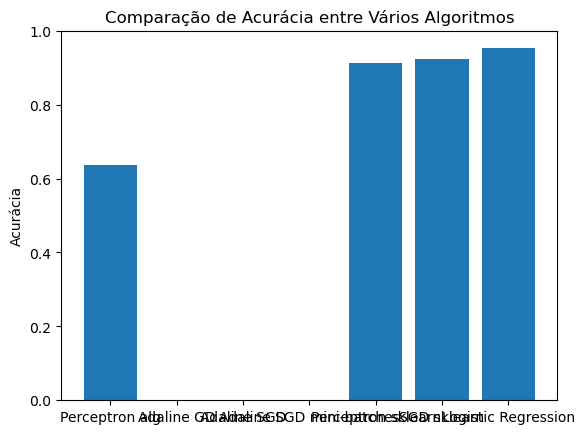

In [97]:
# Plotar o gráfico de barras das acurácias
import matplotlib.pyplot as plt
labels = ['Perceptron alg', 'Adaline GD', 'Adaline SGD', 'Adaline SGD mini-batches', 'Perceptron sklearn','SGD sklearn',  'Logistic Regression']
plt.bar(np.arange(7), accuracies)
plt.xticks(np.arange(7), labels)
plt.ylabel('Acurácia')
plt.ylim([0, 1])
plt.title('Comparação de Acurácia entre Vários Algoritmos')
plt.show()